In [1]:
import time

import pandas as pd
from ragas import evaluate, RunConfig
from datasets import Dataset

import openai
import os
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision
)

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

/Users/vasilisa/miniconda3/envs/ai_guide_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ld/jmjl5j656sv7yzc3p_2dds_80000gp/T/ipykernel_30824/1221157216.py:11: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import (
/var/folders/ld/jmjl5j656sv7yzc3p_2dds_80000gp/T/ipykernel_30824/1221157216.py:11: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import answer_relevancy
  from ragas.metrics import (
/var/folders/ld/jmjl5j656sv7yzc3p_2dds_80000gp/T/ipykerne

In [11]:
# загрузка данных (вставить нужный датасет)
df = pd.read_json("../evaluation/answers_rag_haiiku_4_5.jsonl", lines=True)
# df = df[1:].copy()
df['contexts'] = df['contexts'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)
# df.drop(columns=["clarified_query"], inplace=True)
df.head()

,question,answer,contexts,ground_truth
0,What documents do I need to travel internation...,"Based on the provided context, here are the do...","[customs. Also, do get a Travel insurance whic...","For international travel, you typically need a..."
1,What is the Eiffel Tower's location?,The context provided does not specify the loca...,"[Of course, you can also take the funicular. 4...","The Eiffel Tower is located in Paris, France. ..."
2,What are the typical business hours in Spain?,"In Spain, the typical business hours for most ...","[customary schedule for work, dining and store...",Business hours in Spain typically follow the p...
3,What currency is used in Japan?,The currency used in Japan is the Japanese yen...,[baths (by reservation or attached to your roo...,The currency used in Japan is the Japanese Yen...
4,What is the best time to visit the Great Barri...,"Based on the context provided, the best time t...","[(about 1/2 hr by boat, Great Barrier Reef abo...",The best time to visit the Great Barrier Reef ...


In [12]:
eval_dataset = Dataset.from_pandas(df)

print("Данные загружены")
print(f"Количество строк: {len(eval_dataset)}")

Данные загружены
Количество строк: 100


In [13]:
eval_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 100
})

In [14]:
# OPEN AI токен
os.environ["OPENAI_API_KEY"] = ''
print("OpenAI настроен")

OpenAI настроен


In [15]:
llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="gpt-4o",
        temperature=0,
        n=3,              # ВАЖНО
        # max_tokens=768,   # чтобы ответы не обрывались
        request_timeout=180,
        
    )
)

/var/folders/ld/jmjl5j656sv7yzc3p_2dds_80000gp/T/ipykernel_30824/18494756.py:1: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  llm = LangchainLLMWrapper(


In [16]:
# Embeddings через LangChain wrapper
embeddings = LangchainEmbeddingsWrapper(
    OpenAIEmbeddings(
        model="text-embedding-3-small"
    )
)
print("LLM и Embeddings настроены")


LLM и Embeddings настроены


/var/folders/ld/jmjl5j656sv7yzc3p_2dds_80000gp/T/ipykernel_30824/151111821.py:2: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  embeddings = LangchainEmbeddingsWrapper(


In [17]:
# настройка нужных метрик
metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision
]

print("Метрики выбраны")

Метрики выбраны


In [18]:
run_config = RunConfig(
    timeout=180,
    max_retries=2,
)

In [19]:
results = []

BATCH_SIZE = 4      # НЕ БОЛЬШЕ
SLEEP_BETWEEN = 65  # секунд

for i in range(0, len(eval_dataset), BATCH_SIZE):
    batch = eval_dataset.select(range(i, min(i + BATCH_SIZE, len(eval_dataset))))
    
    print(f"Оцениваем batch {i}–{i+len(batch)}")
    
    result = evaluate(
        dataset=batch,
        metrics=metrics,
        llm=llm,
        embeddings=embeddings,
        run_config=run_config,
    )
    
    results.append(result.to_pandas())
    
    print("Спим, чтобы сбросился TPM...")
    time.sleep(SLEEP_BETWEEN)

Оцениваем batch 0–4


Evaluating:   6%|▋         | 1/16 [00:05<01:28,  5.91s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:59<00:00,  3.70s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 4–8


Evaluating:   6%|▋         | 1/16 [00:05<01:16,  5.08s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 8–12


Evaluating:   6%|▋         | 1/16 [00:05<01:22,  5.48s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:56<00:00,  3.50s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 12–16


Evaluating:   6%|▋         | 1/16 [00:04<01:12,  4.84s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:54<00:00,  3.41s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 16–20


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 20–24


Evaluating:   6%|▋         | 1/16 [00:04<01:12,  4.81s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:54<00:00,  3.43s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 24–28


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:54<00:00,  3.42s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 28–32


Evaluating:   6%|▋         | 1/16 [00:05<01:24,  5.60s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 32–36


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:56<00:00,  3.50s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 36–40


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating:   6%|▋         | 1/16 [00:09<02:17,  9.16s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:58<00:00,  3.65s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 40–44


Evaluating:   6%|▋         | 1/16 [00:04<01:13,  4.91s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:53<00:00,  3.36s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 44–48


Evaluating:   6%|▋         | 1/16 [00:04<01:12,  4.83s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 48–52


Evaluating:   6%|▋         | 1/16 [00:04<01:13,  4.90s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 52–56


Evaluating:   6%|▋         | 1/16 [00:04<01:12,  4.85s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 56–60


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 60–64


Evaluating:   6%|▋         | 1/16 [00:04<01:14,  4.96s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:57<00:00,  3.58s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 64–68


Evaluating:   6%|▋         | 1/16 [00:05<01:15,  5.05s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:53<00:00,  3.37s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 68–72


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:58<00:00,  3.64s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 72–76


Evaluating:   6%|▋         | 1/16 [00:05<01:16,  5.10s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 76–80


Evaluating:   6%|▋         | 1/16 [00:04<01:14,  4.94s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:57<00:00,  3.57s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 80–84


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:56<00:00,  3.51s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 84–88


Evaluating:   6%|▋         | 1/16 [00:04<01:13,  4.91s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 88–92


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 92–96


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:53<00:00,  3.35s/it]


Спим, чтобы сбросился TPM...
Оцениваем batch 96–100


Evaluating:  12%|█▎        | 2/16 [00:10<01:12,  5.20s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it]


Спим, чтобы сбросился TPM...


In [20]:
results

[                                          user_input  \
 0  What documents do I need to travel internation...   
 1               What is the Eiffel Tower's location?   
 2      What are the typical business hours in Spain?   
 3                    What currency is used in Japan?   
 
                                   retrieved_contexts  \
 0  [customs. Also, do get a Travel insurance whic...   
 1  [Of course, you can also take the funicular. 4...   
 2  [customary schedule for work, dining and store...   
 3  [baths (by reservation or attached to your roo...   
 
                                             response  \
 0  Based on the provided context, here are the do...   
 1  The context provided does not specify the loca...   
 2  In Spain, the typical business hours for most ...   
 3  The currency used in Japan is the Japanese yen...   
 
                                            reference  faithfulness  \
 0  For international travel, you typically need a...      0.916667 

In [21]:
df_result = pd.concat(results, ignore_index=True)


In [22]:
df_result.to_csv('ragas_evaluation_results_mistral_small_baseline.csv', index=False)

In [23]:
df_result

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision
0,What documents do I need to travel internation...,"[customs. Also, do get a Travel insurance whic...","Based on the provided context, here are the do...","For international travel, you typically need a...",0.916667,0.963974,0.5,0.5
1,What is the Eiffel Tower's location?,"[Of course, you can also take the funicular. 4...",The context provided does not specify the loca...,"The Eiffel Tower is located in Paris, France. ...",0.500000,0.000000,0.0,0.0
2,What are the typical business hours in Spain?,"[customary schedule for work, dining and store...","In Spain, the typical business hours for most ...",Business hours in Spain typically follow the p...,0.937500,0.935428,0.5,0.5
3,What currency is used in Japan?,[baths (by reservation or attached to your roo...,The currency used in Japan is the Japanese yen...,The currency used in Japan is the Japanese Yen...,1.000000,0.824035,1.0,1.0
4,What is the best time to visit the Great Barri...,"[(about 1/2 hr by boat, Great Barrier Reef abo...","Based on the context provided, the best time t...",The best time to visit the Great Barrier Reef ...,0.545455,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
95,What are the main principles of Keynesian econ...,[Milton Keynes is a very large town in the Sou...,The provided context does not contain any info...,This question is off-topic for tourism and tra...,1.000000,0.000000,0.0,0.0
96,How do I start a podcast?,[Mawddach Way. Walk the 49-km-long circular fo...,The context provided does not contain any info...,This question is off-topic for tourism and tra...,0.090909,0.964140,1.0,0.0
97,What is machine learning?,[viewers. A computer program called AlphaGo be...,The provided context does not contain any info...,This question is off-topic for tourism and tra...,0.500000,0.000000,0.0,0.0
98,How can I improve my public speaking skills?,[level of English is more advanced than a visi...,The context provided does not contain informat...,This question is off-topic for tourism and tra...,0.500000,0.000000,0.0,0.0


## Оценка полученного результата на валидационном датасете от Haiku

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [33]:
haiku_results = pd.read_csv('ragas_evaluation_results_mistral_small_baseline.csv')
print("Не рассчитанные метрики по вопросам")
haiku_results.isna().sum()

Не рассчитанные метрики по вопросам


user_input            0
retrieved_contexts    0
response              0
reference             0
faithfulness          0
answer_relevancy      0
context_recall        0
context_precision     0
dtype: int64

In [34]:
haiku_results.describe()

,faithfulness,answer_relevancy,context_recall,context_precision
count,100.000000,100.000000,100.000000,100.000000
mean,0.676330,0.742642,0.317952,0.175972
std,0.277698,0.389502,0.413410,0.323485
min,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.777128,0.000000,0.000000
50%,0.738636,0.941338,0.000000,0.000000
75%,0.918269,0.986107,0.541667,0.250000
max,1.000000,1.000000,1.000000,1.000000


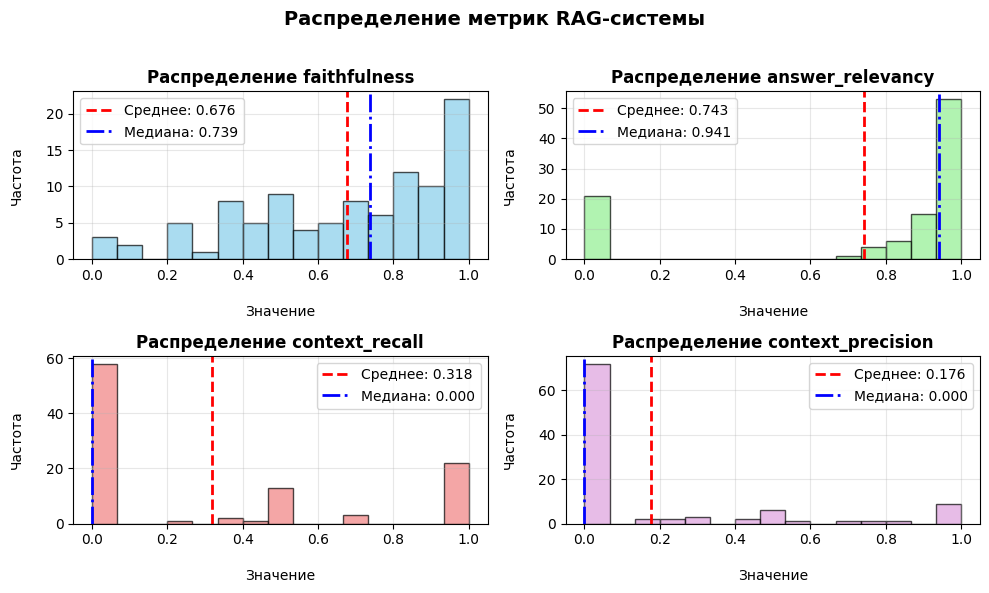

In [35]:
# распределения метрик 

metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i]
    data = haiku_results[metric]
    
    # Гистограмма
    ax.hist(data, bins=15, alpha=0.7, color=color, edgecolor='black')
    
    # Вычисляем статистики
    mean_val = data.mean()
    median_val = data.median()
    
    # Линии среднего и медианы
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее: {mean_val:.3f}')
    ax.axvline(median_val, color='blue', linestyle='-.', linewidth=2, 
               label=f'Медиана: {median_val:.3f}')
    
    ax.set_title(f'Распределение {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('\nЗначение')
    ax.set_ylabel('Частота\n')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Распределение метрик RAG-системы\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [36]:
# добавим контекста по типам вопросов 
ground_truth_answers = pd.read_csv('../tourism_travel_questions_with_ground_truth_ver_short.csv')[['question', 'difficulty_level', 'question_type','topic']]

ground_truth_answers
haiku_results_with_topics = haiku_results.merge(ground_truth_answers, 
                                                    left_on='user_input',
                                                    right_on='question',
                                                    validate='1:1')\
                                            .drop(columns=['question'])\
                                            .copy()

haiku_results_with_topics.head(3)

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision,difficulty_level,question_type,topic
0,What documents do I need to travel internation...,"[""customs. Also, do get a Travel insurance whi...","Based on the provided context, here are the do...","For international travel, you typically need a...",0.916667,0.963974,0.5,0.5,easy,factual,safety
1,What is the Eiffel Tower's location?,"['Of course, you can also take the funicular. ...",The context provided does not specify the loca...,"The Eiffel Tower is located in Paris, France. ...",0.500000,0.000000,0.0,0.0,easy,factual,attractions
2,What are the typical business hours in Spain?,"['customary schedule for work, dining and stor...","In Spain, the typical business hours for most ...",Business hours in Spain typically follow the p...,0.937500,0.935428,0.5,0.5,easy,factual,culture


In [37]:
# Статистика по уровням сложности
print("=" * 60)
print("СТАТИСТИКА ПО УРОВНЯМ СЛОЖНОСТИ (difficulty_level):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = haiku_results_with_topics.groupby('difficulty_level')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

# Статистика по типам вопросов
print("\n" + "=" * 60)
print("СТАТИСТИКА ПО ТИПАМ ВОПРОСОВ (question_type):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = haiku_results_with_topics.groupby('question_type')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

# Статистика по темам
print("\n" + "=" * 60)
print("СТАТИСТИКА ПО ТЕМАМ (topic):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = haiku_results_with_topics.groupby('topic')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

СТАТИСТИКА ПО УРОВНЯМ СЛОЖНОСТИ (difficulty_level):

Метрика: faithfulness
                  count   mean    std    min  median  max
difficulty_level                                         
easy                 28  0.734  0.276  0.000   0.829  1.0
hard                 27  0.608  0.265  0.000   0.611  1.0
medium               28  0.740  0.256  0.000   0.789  1.0
off-topic            17  0.585  0.307  0.091   0.500  1.0
----------------------------------------

Метрика: answer_relevancy
                  count   mean    std    min  median    max
difficulty_level                                           
easy                 28  0.810  0.342  0.000   0.963  1.000
hard                 27  0.810  0.299  0.000   0.927  1.000
medium               28  0.971  0.041  0.841   0.989  1.000
off-topic            17  0.149  0.333  0.000   0.000  0.964
----------------------------------------

Метрика: context_recall
                  count   mean    std  min  median  max
difficulty_level           

### Если убрать оффтопик вопросы 

In [38]:
haiku_results_no_offtopic = haiku_results_with_topics.query('difficulty_level != "off-topic"').reset_index(drop=True)
print('Количество запросов не off-topic:', haiku_results_no_offtopic.shape[0])

Количество запросов не off-topic: 83


In [39]:
haiku_results_no_offtopic.describe()

,faithfulness,answer_relevancy,context_recall,context_precision
count,83.000000,83.000000,83.000000,83.000000
mean,0.695021,0.864325,0.358979,0.212015
std,0.269441,0.270763,0.418088,0.344386
min,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.892428,0.000000,0.000000
50%,0.777778,0.962226,0.000000,0.000000
75%,0.919872,0.989798,0.666667,0.375000
max,1.000000,1.000000,1.000000,1.000000


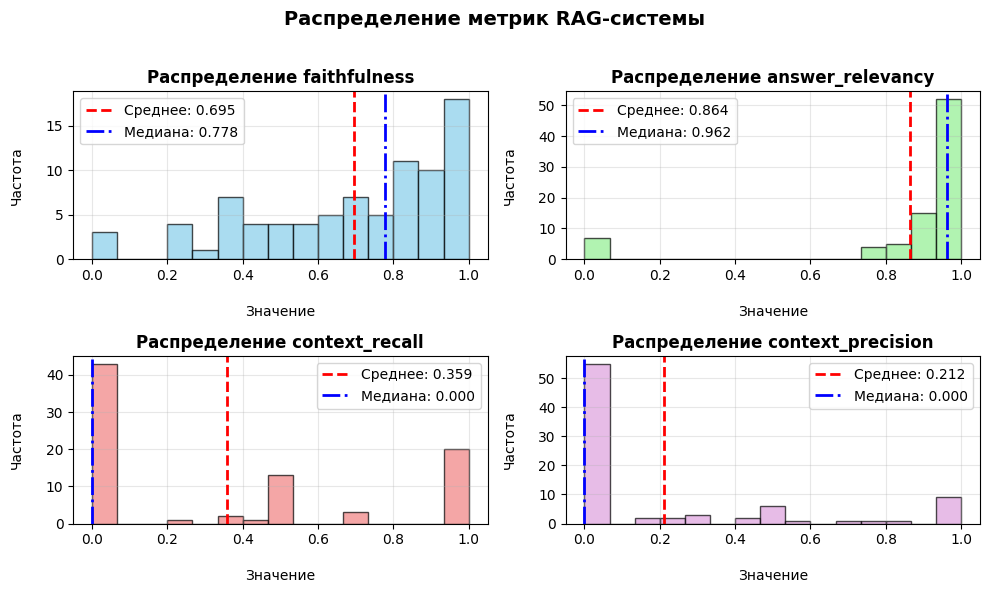

In [40]:
# распределения метрик 

metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i]
    data = haiku_results_no_offtopic[metric]
    
    # Гистограмма
    ax.hist(data, bins=15, alpha=0.7, color=color, edgecolor='black')
    
    # Вычисляем статистики
    mean_val = data.mean()
    median_val = data.median()
    
    # Линии среднего и медианы
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее: {mean_val:.3f}')
    ax.axvline(median_val, color='blue', linestyle='-.', linewidth=2, 
               label=f'Медиана: {median_val:.3f}')
    
    ax.set_title(f'Распределение {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('\nЗначение')
    ax.set_ylabel('Частота\n')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Общий заголовок
plt.suptitle('Распределение метрик RAG-системы\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()